This notebook serves as an example for the main functions of visualeyes. Running this code does require having the vizeyes environment built, and having the Eyelink Developers Kit installed. 

In [1]:
import os
import eyelinkio
import pandas as pd
import sys
import matplotlib.pyplot as plt

import visualeyes

#### Fetch Example Data

In [2]:
# define the path to the edf file
current_path = os.getcwd()
data_dir = os.path.abspath(os.path.join(current_path, "..", "data"))
edf_path = os.path.join(data_dir, 'TG_2015.EDF')

In [3]:
# read the edf file
edf = eyelinkio.read_edf(edf_path)

# convert the edf file to a dicitionary of pandas dataframes
edf_dfs = edf.to_pandas()

loadEvents = 1
setTrial End:  END
loadEvents = 1


#### Example 1: visualize data quality of the entire experiment as a gaze heatmap

In [4]:
# add time column to the dataframes
edf_dfs['samples']['time'] = edf['times']
all_data = edf_dfs['samples']

In [5]:
# define the areas of interest (AOIs) 
aoi_definitions =[{'shape': 'circle', 'coordinates': (650, 400, 100)},
                  {'shape': 'circle', 'coordinates': (100, 400, 100)},
                  {'shape': 'circle', 'coordinates': (1100, 400, 100)}]

#extract screen coords from edf object
width, height = edf['info']['screen_coords']

aoi_mask = visualeyes.define_aoi((height, width), aoi_definitions)

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='X Position (pixels)', ylabel='Y Position (pixels)'>)

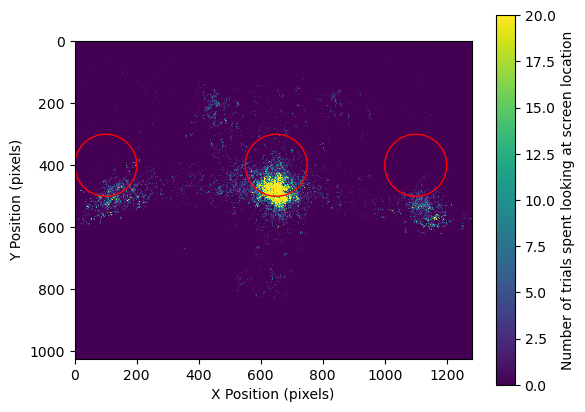

In [6]:
visualeyes.plot_heatmap(all_data, screen_dimensions = (height, width), aoi_definitions=aoi_definitions, bins=(width, height))

This heatmap shows that our participant spent the majority of their time looking just under our areas of interest. If we saw this mid-experiment, we might check the calibration or reinstruct our participant. 

We currently have our colorbar hardcoded, but in future iterations, we will allow users to set this to see patterns that might be obfuscated if they have more trials than we do. 

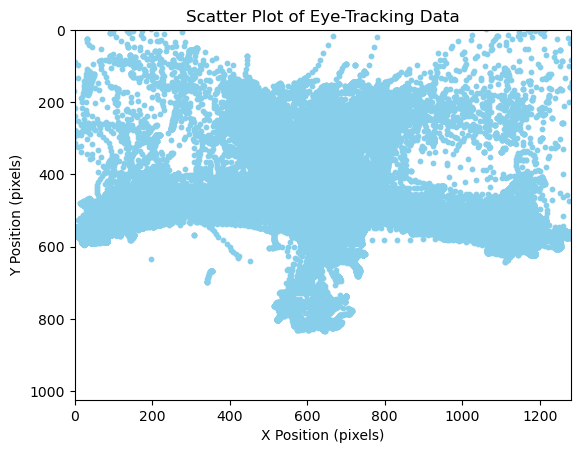

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Scatter Plot of Eye-Tracking Data'}, xlabel='X Position (pixels)', ylabel='Y Position (pixels)'>)

In [19]:
def plot_scatter(data, screen_dimensions, marker_size=10):
    """
    Plots a scatter plot of eye-tracking data with the origin at the top-left corner.
    
    Parameters:
    - data: DataFrame containing 'xpos' and 'ypos' columns for plotting.
    - screen_dimensions: Tuple of (screen_height, screen_width).
    - marker_size: Size of the markers in the scatter plot.
    """
    # Extract screen height and width
    screen_height, screen_width = screen_dimensions
    
    # Initialize the plot
    fig, ax = plt.subplots()

    # Adjust y-coordinate to match the top-left origin
    adjusted_ypos = screen_height - data['ypos']

    # Plot the data as a scatter plot
    ax.scatter(x=data['xpos'], y=adjusted_ypos, color='skyblue', marker='o', s=marker_size)

    # Set the axis limits to match screen dimensions
    ax.set_xlim(0, screen_width)
    ax.set_ylim(0, screen_height)

    # Invert y-axis to match the screen coordinates
    ax.invert_yaxis()

    # Add labels and title
    ax.set_xlabel('X Position (pixels)')
    ax.set_ylabel('Y Position (pixels)')
    ax.set_title('Scatter Plot of Eye-Tracking Data')

    # Show the plot
    plt.show()

    return fig, ax

plot_scatter(all_data, screen_dimensions=(height, width))

In [9]:
# calculate the percentage of data points in all AOIs
percent_data = visualeyes.percent_data_in_aoi(all_data, aoi_mask, screen_dimensions=(height, width))
percent_data

np.float64(12.897291248781464)

Our participant only spent 12% of their time looking where we wanted them to, backing up our conclusion from the heatmap that our participant might need reinstruction. 

#### Example 2: visualize looking behavior during the first 300ms of each trial

For some developmental work, we might only want to confirm that our particpants were looking at our AOIs at the beginning of our trials, so we can check this out by just looking at those timepoints.

In [10]:
# get trial data
trial_data = edf_dfs['discrete']['trials']

# epoch the first 300ms of every trial
trial_start = trial_data['stime'].values
duration = 300/1000 # 300ms = 0.3s

# get the data, here we are interested in all samples collected
all_data = edf_dfs['samples']

# epoch the data
epochs, epoched_data = visualeyes.epoch_data(all_data, trial_start, duration)
epoched_data

,xpos,ypos,ps,time,epoch_index
0,599.200012,452.500000,510.0,0.000,0
1,599.500000,454.200012,511.0,0.002,0
2,600.000000,455.899994,511.0,0.004,0
3,600.400024,457.299988,512.0,0.006,0
4,600.700012,459.100006,513.0,0.008,0
...,...,...,...,...,...
664938,773.200012,544.400024,147.0,1329.876,89
664939,773.099976,545.200012,147.0,1329.878,89
664940,773.000000,545.700012,147.0,1329.880,89
664941,773.000000,546.200012,148.0,1329.882,89


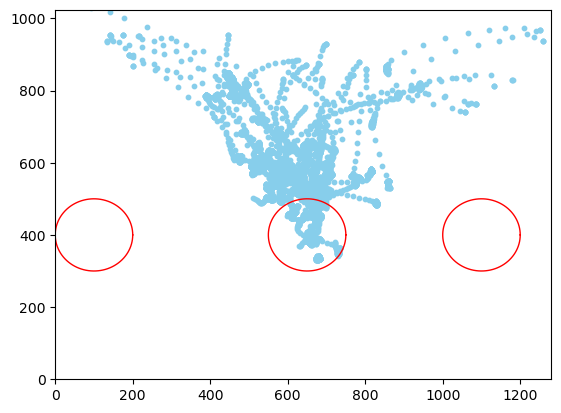

In [16]:
_ = visualeyes.plot_as_scatter(epoched_data, screen_dimensions=(height, width),
                           aoi_definitions=aoi_definitions, marker_size=10)

With this plot, we can see that our participant typically started the trials looking at the top of the screen. 

I think the difference is mainly the 300 ms and the plot inversion!